# Intra and Cloud Flare latency test

### Imports

In [1]:
import requests # type: ignore
import time
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import concurrent.futures
from functools import partial
from datetime import datetime
import threading
import json
import statistics
from scipy.stats import norm # type: ignore

### Main function that performs multiple requests by evaluating the latency of an API

In [ ]:
def test_api_performance(url, barrier, num_requests=10, timeout=0.5):
    response_times = []
    print(f"{datetime.now()} - Starting thread execution")

    for i in range(num_requests):
        barrier.wait()
        request_start_time = time.time()
        print(f"{datetime.now()} - Request {i+1}")

        try:
            response = requests.get(url, verify='cacert.pem', timeout=timeout)
            request_end_time = time.time()

            elapsed_time = request_end_time - request_start_time
            response_times.append(elapsed_time)

            #print(f"{datetime.now()} - Request {i+1}: Response time = {elapsed_time:.4f} seconds, HTTP Status = {response.status_code}")

        except requests.exceptions.Timeout:
            print(f"{datetime.now()} - Request {i+1}: Timed out after {timeout * 1000} ms")

        except requests.exceptions.RequestException as e:
            print(f"{datetime.now()} - Request {i+1}: Failed with error {e}")



    return response_times

### Functions to plot graphs about response time

In [ ]:
def plot_histogram(response_times, dictionary):
    plt.figure(figsize=(10, 6))
    i=0
    names = list(dictionary["APIs"])
    for response_time in response_times:
        plt.hist(response_time, bins=10, alpha=0.5, label=names[i], color=dictionary["APIs"][names[i]]["color"])
        i+=1

    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Response Times')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_boxplot(response_times, dictionary):
    names = list(dictionary["APIs"])
    plt.figure(figsize=(8, 6))
    plt.boxplot(response_times, tick_labels=names)
    plt.ylabel('Response Time (seconds)')
    plt.title('Boxplot of Response Times')
    mean=[]
    i=0
    for response_time in response_times:
        mean.append(int(np.mean(response_time)*10000)/10000)
        plt.figtext(1,(8-i*0.5)/10, names[i] + " : median " + str(int(np.median(response_time)*10000)/10000)
                                             + " / mean " + str(int(np.mean(response_time)*10000)/10000))
        i+=1
    plt.grid(True)
    plt.show()

def plot_cdf(response_times, dictionary):
    names = list(dictionary["APIs"])
    i=0
    plt.figure(figsize=(10, 6))
    for response_time in response_times:
        sorted_times = np.sort(response_time)
        cdf = np.arange(len(sorted_times)) / float(len(sorted_times))
        plt.plot(sorted_times, cdf, label=names[i], color=dictionary["APIs"][names[i]]["color"])
        i+=1
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('CDF')
    plt.title('Cumulative Distribution Function (CDF) of Response Times')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_time_series(response_times, dictionary):
    plt.figure(figsize=(10, 6))
    names = list(dictionary["APIs"])
    i=0
    for response_time in response_times:
        plt.plot(response_time, marker='o', linestyle='-', label=names[i], color=dictionary["APIs"][names[i]]["color"])
        i+=1
    plt.xlabel('Request Number')
    plt.ylabel('Response Time (seconds)')
    plt.title('Response Times Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_heatmap(response_times, dictionary):
    data = np.array(response_times)
    plt.figure(figsize=(8, 6))
    names = list(dictionary["APIs"])
    sns.heatmap(data, annot=False, cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=names)
    plt.title('Heatmap of Response Times')
    plt.xlabel('Request Number')
    plt.ylabel('API')
    plt.show()

In [4]:
#Getting the API calls from the json file config.json

f = open('config.json')
data= json.load(f)
f.close()

url_data = data["APIs"]

#Getting names of the APIs
names=list(url_data)

#Getting execution variables

num_requests = data["execution"]["number"]
timeout = data["execution"]["timeout"]

print(url_data)

FileNotFoundError: [Errno 2] No such file or directory: 'config.json'

### APIs used, collection of performance data and simultaneous simulation

In [85]:
response_times = []

# Collecting performance data
barrier = threading.Barrier(len(url_data))
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(test_api_performance, url_data[api_name]["url"], barrier, num_requests, timeout) for api_name in url_data]
    concurrent.futures.wait(futures)

for future in concurrent.futures.as_completed(futures):
    response_times.append(future.result())

2024-09-12 15:05:10.621717 - Starting thread execution
2024-09-12 15:05:10.634958 - Starting thread execution
2024-09-12 15:05:10.634958 - Request 1
2024-09-12 15:05:10.634958 - Request 1
2024-09-12 15:05:11.384077 - Request 22024-09-12 15:05:11.384077 - Request 2

2024-09-12 15:05:11.934892 - Request 32024-09-12 15:05:11.934892 - Request 3

2024-09-12 15:05:12.550093 - Request 42024-09-12 15:05:12.550093 - Request 4

2024-09-12 15:05:13.129107 - Request 52024-09-12 15:05:13.129107 - Request 5

2024-09-12 15:05:13.715202 - Request 6
2024-09-12 15:05:13.716202 - Request 6
2024-09-12 15:05:14.297854 - Request 72024-09-12 15:05:14.297854 - Request 7

2024-09-12 15:05:14.914165 - Request 82024-09-12 15:05:14.914165 - Request 8

2024-09-12 15:05:15.479502 - Request 92024-09-12 15:05:15.479502 - Request 9

2024-09-12 15:05:16.015121 - Request 102024-09-12 15:05:16.015121 - Request 10

2024-09-12 15:05:16.530308 - Request 112024-09-12 15:05:16.530308 - Request 11

2024-09-12 15:05:17.079655 -

In [ ]:
#Comparaison

print(response_times[0])
print(response_times[1])

reference = data["execution"]["test_reference"]

print(reference)

[0.5702109336853027, 0.6130349636077881, 0.5973639488220215, 0.5935020446777344, 0.6770620346069336, 0.583411455154419, 0.6742475032806396, 0.6556174755096436, 0.5956861972808838, 1.4061310291290283, 0.6198170185089111, 0.5804076194763184, 0.583350658416748, 0.5979177951812744, 0.6101586818695068, 1.437561273574829, 0.7952439785003662, 0.7004129886627197, 0.6887493133544922, 0.5646932125091553, 0.6321992874145508, 1.4319381713867188, 0.6743521690368652, 0.5831291675567627, 0.5846176147460938, 0.5913426876068115, 0.548393726348877, 0.5668544769287109, 0.5881197452545166, 0.554389476776123, 0.5701162815093994, 0.5833547115325928, 0.6722574234008789, 0.6806697845458984, 0.6663632392883301, 0.700139045715332, 0.6165800094604492, 0.6496436595916748, 0.5689711570739746, 0.6160156726837158, 0.6187314987182617, 0.6633195877075195, 0.611168622970581, 0.5555601119995117, 0.556983470916748, 0.559424877166748, 0.6849896907806396, 0.5626235008239746, 0.6096405982971191, 0.6265876293182373, 0.636455

### General data

In [ ]:
i=0

average_times = []
median_times = []
stdev_times = []

print("\n--- Performance Test Results ---\n")

for response_time in response_times:
    # Calculate statistics for the current API
    average_time = statistics.mean(response_time)
    median_time = statistics.median(response_time)
    stdev_time = statistics.stdev(response_time)

    average_times.append(average_time)
    median_times.append(median_time)
    stdev_times.append(stdev_time)

    # Display statistics for the first API
    print(f"{names[i]}:")
    print(f"Number of requests: {num_requests}")
    print(f"Average response time: {average_time:.4f} seconds")
    print(f"Median response time: {median_time:.4f} seconds")
    print(f"Standard deviation of response time: {stdev_time:.4f} seconds")
    print(f"Minimum response time: {min(response_time):.4f} seconds")
    print(f"Maximum response time: {max(response_time):.4f} seconds")

    print("\n")

    i+=1


print("--- Comparaison entre APIs ---\n")

for i in range(1,len(average_times)):
    # Calculate statistics for the reference API

    pourcentage_average = (average_times[0] - average_times[i])/average_times[0] * 100
    pourcentage_median = (median_times[0] - median_times[i])/average_times[0] * 100

    # Display statistics for the first API

    if pourcentage_average>0:
        print(f"{names[i]}: \n")
        print(f"The average response time of the {names[0]} is : {pourcentage_average:.4f} % slower than the {names[i]}")
    else:
        print(f"{names[i]}: \n")
        print(f"The average response time of the {names[0]} is : {-pourcentage_average:.4f} % faster than the {names[i]}")


    if pourcentage_median>0:
        print(f"The median of the response time of the {names[0]} is : {pourcentage_median:.4f} % slower than the {names[i]}")
    else:
        print(f"The median of the response time of the {names[0]} is : {-pourcentage_median:.4f} % faster than the {names[i]}")

    print("\n")

    i+=1


--- Performance Test Results ---

API Cloud Flare:
Number of requests: 100
Average response time: 0.6349 seconds
Median response time: 0.5979 seconds
Standard deviation of response time: 0.1514 seconds
Minimum response time: 0.5333 seconds
Maximum response time: 1.4376 seconds


API Intra:
Number of requests: 100
Average response time: 0.5919 seconds
Median response time: 0.5614 seconds
Standard deviation of response time: 0.1322 seconds
Minimum response time: 0.4917 seconds
Maximum response time: 1.4366 seconds


--- Comparaison entre APIs ---

API Intra: 

The average response time of the API Cloud Flare is : 6.7721 % slower than the API Intra
The median of the response time of the API Cloud Flare is : 5.7585 % slower than the API Intra




### Histogram of Response Times

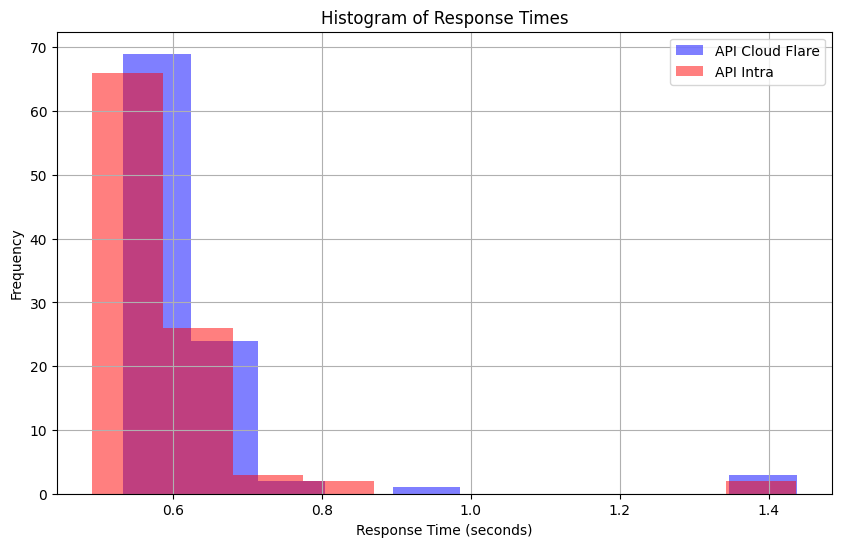

In [79]:
plot_histogram(response_times,data)

#### Analysis of the results

Here we can see a pretty close overall tendency of both APIs. We need more information about those two APIs.

### Boxplots of Response Times

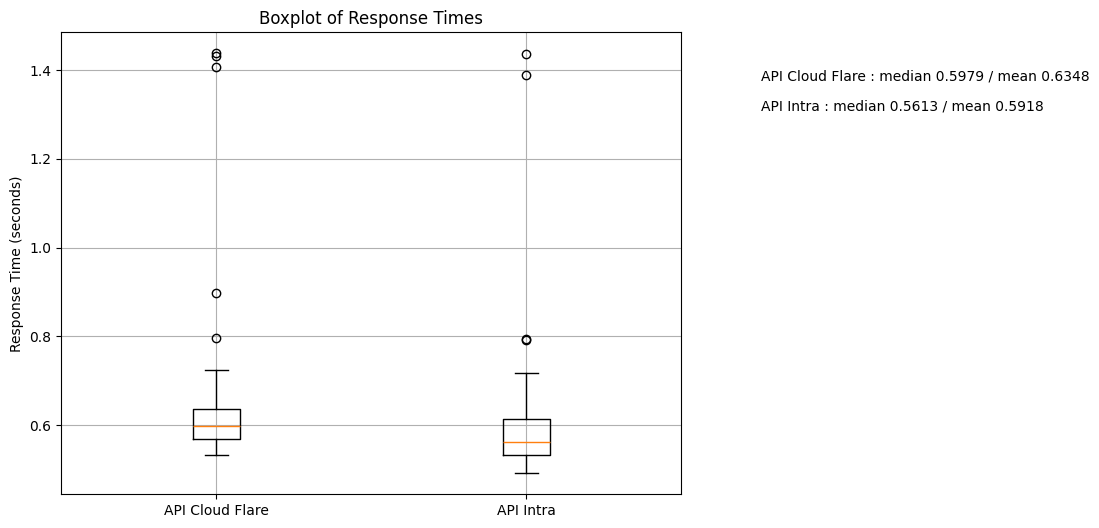

In [80]:
plot_boxplot(response_times,data)

### Cumulative Distribution Function (CDF) of Response Times

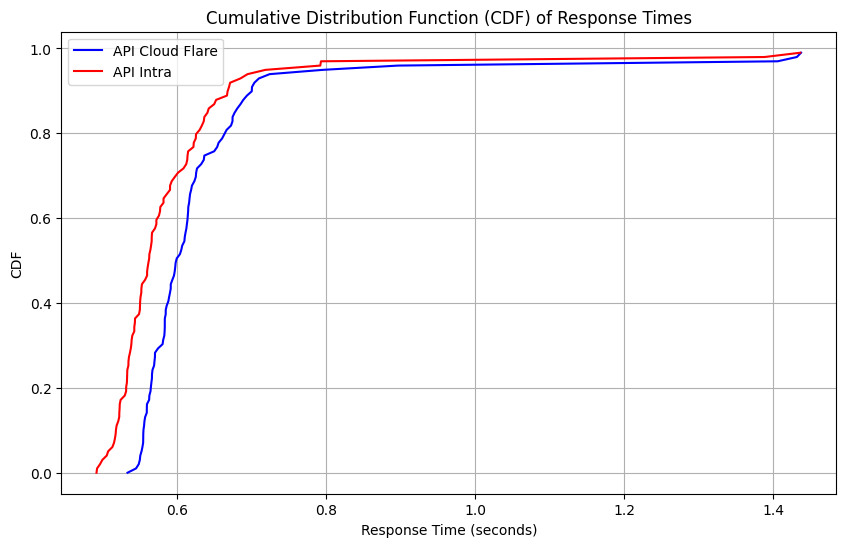

In [81]:
plot_cdf(response_times, data)

#### Definition of Cumulative Distribution Function 

The Cumulative Distribution Function is a concept used in statistics to describe the probability that a random variable takes the value less than or equal to a certain value.

The CDF of a random variable X is a function F(x) that gives the probability that X is less than or equal to x. Formally, for a continuous variable :

$$
F(x) = P(X \leq x)
$$

#### Analysis of the results

Here we can see that the API Intra has a CDF curve under the API Cloud Flare curve in function of the response time in seconds. 

So we can deduce that the API Cloud Flare has in general a better time response as it gets faster to 100% probability of getting the response.

### Response Times Over Time

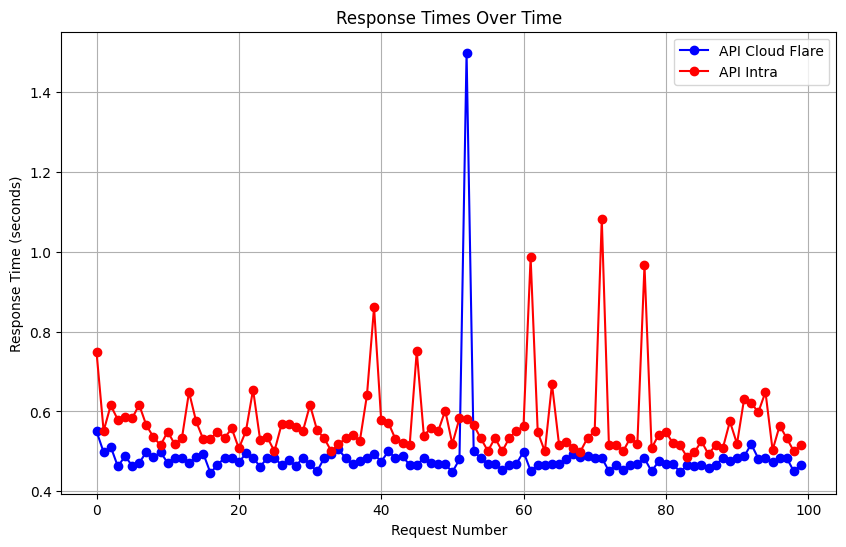

In [86]:
plot_time_series(response_times, data)

#### Analysis of the results

Here we can see that the highest Response times are reached by the Cloud Flare API. So even though we saw before that the Intra has a higher overall response time, the Cloud Flare API reach sometimes high time responses.

### Heatmap of Response Times

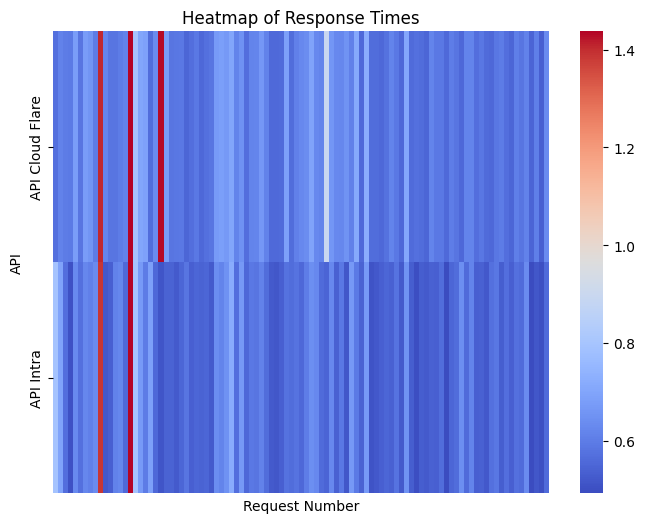

In [83]:
plot_heatmap(response_times, data)